In [1]:
import numpy as np
from copy import copy
import math
import pandas as pd
import torch
import matplotlib.pyplot as plt
from stable_baselines3 import A2C
import stable_baselines3.common.env_checker as check
import gym
import sys
#the directory that contains all the required resources
sys.path.append("model")
import stock_env
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3 import DDPG

# Data

Read data from csv

In [2]:
train_df = pd.read_csv("model/direct/train.csv")
test_df = pd.read_csv("model/direct/test.csv")

see how many days and features we can select from

In [3]:
STOCK_NUM = 26
print(train_df.shape[0]/STOCK_NUM,train_df.shape[1])
print(test_df.shape[0]/STOCK_NUM,test_df.shape[1])

1454.0 15
806.0 15


have a glimpse of how data look like

In [11]:
print(train_df.iloc[:26])

          date     tic     open     high      low    close    volume  \
0   2014-01-16       2  1025.49  1030.72  1017.63  1026.79  476950.0   
1   2014-01-16     725     6.97     7.00     6.90     6.94  582980.0   
2   2014-01-16     858   259.63   263.23   257.44   260.10  153181.0   
3   2014-01-16     895   375.07   399.68   374.55   386.53   54815.0   
4   2014-01-16    2230   167.07   168.45   162.95   163.69   65664.0   
5   2014-01-16    2352    24.70    25.66    24.68    25.46   19073.0   
6   2014-01-16    2594    39.17    39.17    37.99    38.00   43987.0   
7   2014-01-16  300015   112.81   113.25   109.48   112.17   13616.0   
8   2014-01-16  600028     8.07     8.09     8.02     8.05  211529.0   
9   2014-01-16  600029     4.25     4.29     4.23     4.28  150867.0   
10  2014-01-16  600276   399.87   400.88   391.01   392.34   36824.0   
11  2014-01-16  600309   448.19   462.19   442.75   458.85  131540.0   
12  2014-01-16  600436   106.90   108.25   106.80   107.12    42

# Environment

- make our customized environment
v1 -> reward function = networth change
v2 -> reward function = 0.7 * networth change + 0.3 * transaction returns
v3 -> reward function intends to reflect fluctuation and risk
- detailed mechanism of the environment please refer to the report
- also check our customized environment by standard checker

In [4]:
train_env = gym.make('stock_env/StockTradingEnv-v2', df=train_df)
test_env = gym.make('stock_env/StockTradingEnv-v2', df=test_df)
check.check_env(test_env)
check.check_env(train_env)

parameters for the environment we are running here (no need to run)

In [13]:
# STOCK_NUM = 26
# INI_ACCOUNT_BALANCE = 500000
# FEATURES_LIST = ['close','volume','high','open','low','macd','adx','rsi']
# FEATURES_NUM = len(FEATURES_LIST)
# MIN_TRANS_NUM = 100
# SELL_FEES = 0.0025
# BUY_FEES = 0.002
# STOP_ACCOUNT_BALANCE = 0.3*INI_ACCOUNT_BALANCE

# Agent & training

Here we use agent from stable baseline 3

A2C agent
- this agent has high variance and not guaranteed to gain profits

In [5]:
modelA2C = A2C("MlpPolicy", train_env, verbose=2, n_steps=30,gamma=0.95)
modelA2C.learn(total_timesteps=6000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 1.45e+03  |
|    ep_rew_mean        | 2.99e+05  |
| time/                 |           |
|    fps                | 62        |
|    iterations         | 100       |
|    time_elapsed       | 48        |
|    total_timesteps    | 3000      |
| train/                |           |
|    entropy_loss       | -36.9     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -8.54e+04 |
|    std                | 1         |
|    value_loss         | 2.51e+07  |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1.45e+03 |
|    ep_rew_mean        | 3.61e+05 |
| time/                 |          |
|    fps                | 65       |

Have a glimpse of how well the agent is

In [6]:
DAY = 252
RF = 0.03/DAY

def on_test(model):
        print("total interest rate & sharpe ratio")
        test_int = 0
        count = 0
        for i in range(3):
            count +=1
            obs = test_env.reset()
            rates = []
            actions = []
            daily_return = []
            positions = []
            info = {'net_worth': 500000}
            for i in range(1000):
                pre_share_hold = copy(test_env.share_hold)
                pre_net_worth = info['net_worth']
                action, _ = model.predict(obs)
                obs, reward, done, info = test_env.step(action)
                for i in range(len(pre_share_hold)):
                    pre_share_hold[i] = test_env.share_hold[i] - pre_share_hold[i]
                actions.append(pre_share_hold)
                rates.append(info['net_worth'] / 500000)
                daily_return.append((info['net_worth'] - pre_net_worth) / pre_net_worth)
                positions.append(1-info['balance']/info['net_worth'])
                if done:
                    break
            # print(info['net_worth'], info['shares'],info['trans_reward'])
            interest = info['net_worth'] / 500000 - 1
            test_int += interest
            daily_return = np.array(daily_return)
            sharpe = (daily_return.mean() - RF) / daily_return.std() * math.sqrt(DAY)
            print(f"backtest{count}:",interest,sharpe)
        t = int(test_int / count * 1000) / 1000
        print(f"average total interest rate(3 years) over {count} backtests",t)

In [7]:
on_test(modelA2C)

total interest rate & sharpe ratio
backtest1: 0.006441369000020014 -0.2201483466339749
backtest2: -0.004138043999981189 -0.24777785956432619
backtest3: 0.05527021500001905 -0.07436263059377286
average total interest rate(3 years) over 3 backtests 0.019


DDPG agent
- this agent is too stable

In [23]:
n_actions = train_env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
modelDDPG = DDPG("MlpPolicy", train_env, verbose=2,gamma=0.95,action_noise=action_noise)
modelDDPG.learn(total_timesteps=6000)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.45e+03 |
|    ep_rew_mean     | 4.77e+05 |
| time/              |          |
|    episodes        | 4        |
|    fps             | 49       |
|    time_elapsed    | 118      |
|    total_timesteps | 5816     |
| train/             |          |
|    actor_loss      | -1.1e+04 |
|    critic_loss     | 1.42e+08 |
|    learning_rate   | 0.001    |
|    n_updates       | 4362     |
---------------------------------


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


C:\Users\ZPP\miniconda3\envs\cs175\lib\site-packages\stable_baselines3\common\buffers.py:229: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 4.29GB > 3.12GB
  warnings.warn(


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.45e+03  |
|    ep_rew_mean     | 5.56e+05  |
| time/              |           |
|    episodes        | 4         |
|    fps             | 50        |
|    time_elapsed    | 114       |
|    total_timesteps | 5816      |
| train/             |           |
|    actor_loss      | -8.19e+03 |
|    critic_loss     | 1.99e+08  |
|    learning_rate   | 0.001     |
|    n_updates       | 4362      |
----------------------------------


In [25]:
on_test(modelDDPG)

interest rate & sharpe ratio
backtest1: 0.6568982640000001 0.7287782014654087
backtest2: 0.6568982640000001 0.7287782014654087
backtest3: 0.6568982640000001 0.7287782014654087
average interest rate over 3 backtests 0.656


# Evaluation

Measurements
- total interest rate
- sharpe ratio
- equal weights portfolio

In [8]:
def evaluate(model,turns=3):
    colors = ['b', 'g', 'r', 'c', 'm', 'y']
    total_int = 0
    total_sharpe = 0
    cri_hold = []
    cri = []
    for s in range(26):
        cri_hold.append(10000 / test_df.iloc[s]['close'])
    for turn in range(turns):
        obs = test_env.reset()
        rates = []
        actions = []
        daily_return = []
        positions = []
        info = {'net_worth': 500000}
        for i in range(1000):
            if turn==0:
                cri.append(sum(test_df.iloc[s+i*26]['close']*cri_hold[s] for s in range(26))/260000)
            pre_share_hold = copy(test_env.share_hold)
            pre_net_worth = info['net_worth']
            action, _ = model.predict(obs)
            obs, reward, done, info = test_env.step(action)
            for i in range(len(pre_share_hold)):
                pre_share_hold[i] = test_env.share_hold[i] - pre_share_hold[i]
            actions.append(pre_share_hold)
            rates.append(info['net_worth'] / 500000)
            daily_return.append((info['net_worth'] - pre_net_worth) / pre_net_worth)
            positions.append(1 - info['balance'] / info['net_worth'])
            if done:
                break
        interest = info['net_worth'] / 500000 - 1
        total_int += interest
        s_int = str(int(interest * 1000) / 1000)
        daily_return = np.array(daily_return)
        sharpe = (daily_return.mean() - RF) / daily_return.std() * math.sqrt(DAY)
        total_sharpe += sharpe
        plt.plot(list(range(len(rates))), rates, label=f'trail{turn+1}',color=colors[turn],linewidth=1)
        plt.plot(positions,color=colors[turn],linewidth=0.4,linestyle='--')
    total_int /= turns
    total_sharpe /= turns
    plt.plot(cri,label='STD',linewidth=1.25,color='k')
    plt.xlabel("days")
    plt.legend()
    print("total interest rate:",total_int,"sharpe ratio:",total_sharpe)
    plt.show()

total interest rate: -0.015683686399980322 sharpe ratio: -0.2983179895966207


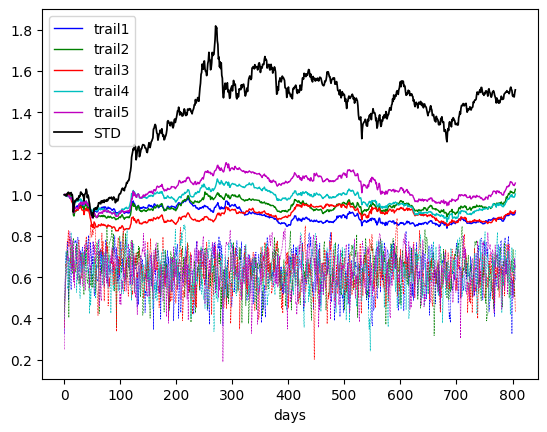

In [9]:
evaluate(modelA2C,turns=5)

total interest rate: 0.6568982640000001 sharpe ratio: 0.7287782014654086


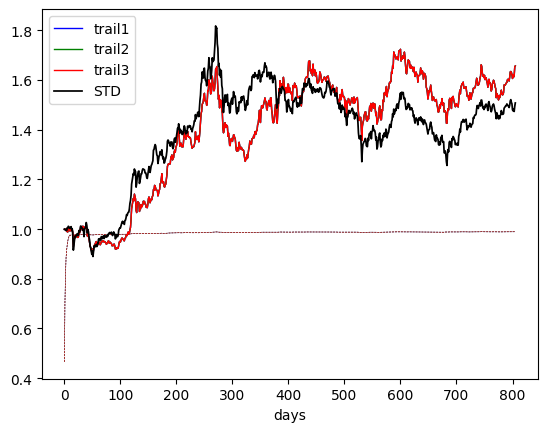

In [31]:
evaluate(modelDDPG)